<div style="background-color: #ccffcc; padding: 10px;">
    <h1> Tutorial 2 </h1> 
    <h2> Physics Informed Neural Networks Part 1</h2>
    <h2> Manual 1D Heat Equation Solver</h2>
</div>    

# Overview

This notebook is based on two papers: *[Physics-Informed Neural Networks:  A Deep LearningFramework for Solving Forward and Inverse ProblemsInvolving Nonlinear Partial Differential Equations](https://www.sciencedirect.com/science/article/pii/S0021999118307125)* and *[Hidden Physics Models:  Machine Learning of NonlinearPartial Differential Equations](https://www.sciencedirect.com/science/article/pii/S0021999117309014)* with the help of  Fergus Shone and Michael Macraild.

These tutorials will go through solving Partial Differential Equations using Physics Informed Neuaral Networks focusing on the Burgers Equation and a more complex example using the Navier Stokes Equation

**This introduction section is replicated in all PINN tutorial notebooks (please skip if you've already been through)** 

<div style="background-color: #ccffcc; padding: 10px;">
If you have not already then in your repositoy directory please run the following code. 
    
```bash
git submodule init
git submodule update --init --recursive
```
    
</div>

<div style="background-color: #ccffcc; padding: 10px;">

<h1>Physics Informed Neural Networks</h1>

For a typical Neural Network using algorithims like gradient descent to look for a hypothesis, data is the only guide, however if the data is noisy or sparse and we already have governing physical models we can use the knowledge we already know to optamize and inform the algoithms. This can be done via [feature enginnering]() or by adding a physicall inconsistency term to the loss function.
<a href="https://towardsdatascience.com/physics-guided-neural-networks-pgnns-8fe9dbad9414">
<img src="https://miro.medium.com/max/700/1*uM2Qh4PFQLWLLI_KHbgaVw.png">
</a>   
  
 
## The very basics

If you know nothing about neural networks there is a [toy neural network python code example](https://github.com/cemac/LIFD_ENV_ML_NOTEBOOKS/tree/main/ToyNeuralNetwork) included in the [LIFD ENV ML Notebooks Repository]( https://github.com/cemac/LIFD_ENV_ML_NOTEBOOKS). Creating a 2 layer neural network to illustrate the fundamentals of how Neural Networks work and the equivlent code using the python machine learning library [tensorflow](https://keras.io/). 

    
## Recommended reading 
    
The in-depth theory behind neural networks will not be covered here as this tutorial is focusing on application of machine learning methods. If you wish to learn more here are some great starting points.   

* [All you need to know on Neural networks](https://towardsdatascience.com/nns-aynk-c34efe37f15a) 
* [Introduction to Neural Networks](https://victorzhou.com/blog/intro-to-neural-networks/)
* [Physics Guided Neural Networks](https://towardsdatascience.com/physics-guided-neural-networks-pgnns-8fe9dbad9414)
* [Maziar Rassi's Physics informed GitHub web Page](https://maziarraissi.github.io/PINNs/)

</div>


<hr>


<div style="background-color: #e6ccff; padding: 10px;">
    
<h1> Machine Learning Theory </h1>
<a href="https://victorzhou.com/series/neural-networks-from-scratch/">
<img src="https://victorzhou.com/media/nn-series/network.svg">
</a>

    
## Physics informed Neural Networks

Neural networks work by using lots of data to calculate weights and biases from data alone to minimise the loss function enabling them to act as universal fuction approximators. However these loose their robustness when data is limited. However by using know physical laws or empirical validated relationships the solutions from neural networks can be sufficiently constrianed by disregardins no realistic solutions.
    
A Physics Informed Nueral Network considers a parameterized and nonlinear partial differential equation in the genral form;
$$
\begin{align}
     u_t + \mathcal{N}[u; \lambda] &= 0, && x \in \Omega, t \in [0,T],\\
\end{align}
$$

where $\mathcal{u(t,x)}$ denores the hidden solution, $\mathcal{N}$ is a nonlinear differential operator acting on $u$, $\mathcal{\lambda}$ and $\Omega$ is a \subset of \mathbb{R}^D$ (the perscribed data). This set up an encapuslate a wide range of problems such as diffusion processes, conservation laws,  advection-diffusion-reaction  systems,  and  kinetic  equations and conservation laws. 

Here we will go though this for the Burgers equation and Navier stokes equations


</div>    

<div style="background-color: #cce5ff; padding: 10px;">

<h1> Python </h1>

    
## Tensorflow 
    
There are many machine learning python libraries available, [TensorFlow](https://www.tensorflow.org/) a is one such library. If you have GPUs on the machine you are using TensorFlow will automatically use them and run the code even faster!

## Further Reading

* [Running Jupyter Notebooks](https://jupyter.readthedocs.io/en/latest/running.html#running)
* [Tensorflow optimizers](https://www.tutorialspoint.com/tensorflow/tensorflow_optimizers.htm)

</div>
    
<hr>

<div style="background-color: #ffffcc; padding: 10px;">
    
<h1> Requirements </h1>

These notebooks should run with the following requirements satisfied

<h2> Python Packages: </h2>

* Python 3
* tensorflow > 2
* numpy as np
* matplotlib
* scipy

<h2> Data Requirements</h2>
    
This notebook referes to some data included in the git hub repositroy
    
</div>


**Contents:**

1. **[1D Heat Equation Non ML Example](PINNs_1DHeatEquations_nonML.ipynb)**
2. [Burgers Equation PINN Example](PINNs_BurgersEquationExample.ipynb)
3. [Navier-Stokes PINNs discovery of PDE’s](PINNs_Navier_Stokes_example.ipynb)



<div style="background-color: #cce5ff; padding: 10px;">
Load in all required modules (includig some auxillary code) and turn off warnings. Make sure Keras session is clear
</div>

In [2]:
# For readability: disable warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
sys.path.insert(0, 'PINNs/Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from time import time
import scipy.sparse as sp
import scipy.sparse.linalg as la

2021-07-15 16:57:02.874406: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-15 16:57:02.874427: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<div style="background-color: #ccffcc; padding: 10px;">

<h1> 1D Heat Equation (forwards) </h1>

Given
- the initial temperature profile $u(x,0) = m(x)$,
- the thermal diffusivity $k$,
- a prescribed temperature $u(0,t) = u(L,t) = 0$ at the extremities of the rod;

solve the heat equation

$$
\left\{
\begin{array}{ll}
\frac{\partial u}{\partial t} - k \frac{\partial^2}{\partial x^2} u = 0 & \forall x\,\in\,(0, L)\; \forall t \in (0,T)\\
u(x, 0) = m(x) & \forall x \in [0,L] \\
u(0,t) = u(L,t) = 0 & \forall t \in (0, T],
\end{array}
\right.
$$

and observe the temperature at the final time $T$:

$$ \mathcal{F}(m) = u(x, T). $$

#### Analytical solution to the forward problem.
    
If

$$ m(x) = \sin\left(n\, \frac{\pi}{L} x \right), \quad n = 1,2,3, \ldots ,$$

then

$$ u(x,t) = e^{ -k\left(n\, \frac{\pi}{L} \right)^2 t} \sin\left(n\,\frac{\pi}{L} x \right) $$

is the unique solution to the heat equation.

</div>

<hr>
<div style="background-color: #ccffcc; padding: 10px;">

<h1> 1D Heat Equation (inverse) </h1>

Given the forward model F and a noisy measurament d of the temperature profile at time T, find the initial temperature profile m

such that
\begin{equation}
F(m)=d.
   \end{equation}
    
### Discretization

To discretize the problem, we use finite differences in space and Implicit Euler in time.

#### Semidiscretization in space
We divide the $[0, L]$ interval in $n_x$ subintervals of the same lenght $h = \frac{L}{n_x}$, and we denote with $u_j(t) := u( jh, t)$ the value of the temperature at point $x_j = jh$ and time $t$.

We then use a centered finite difference approximation of the second derivative in space and write

$$ \frac{\partial u_j(t)}{\partial t} - k \frac{u_{j-1}(t) - 2u_j(t) + u_{j+1}(t)}{h^2} \quad \text{for } j=1,2,\ldots,n_x-1,$$

with the boundary condition $u_0(t) = u_{n_x}(t) = 0$.

By letting

$$ \mathbf{u}(t) = \begin{bmatrix}u_1(t)\\u_2(t)\\ \ldots\\ u_{n_x-1}(t) \end{bmatrix}$$

be the vector collecting the values of the temperature $u$ at the points $x_j = j\,h$, we then write the system of ordinary differential equations (ODEs):
$$ \frac{\partial}{\partial t} \mathbf{u}(t) + K \mathbf{u}(t) = 0,$$
where $K \in \mathbb{R}^{(n_x-1) \times (n_x-1)}$ is the tridiagonal matrix given by

$$ K = \frac{k}{h^2}\begin{bmatrix}  2 & -1 &       &        &        &    \\
                                    -1 &  2 & -1    &        &        &    \\
                                       & -1 &  2    & -1     &        &    \\
                                       &    &\ldots & \ldots & \ldots &    \\
                                       &    &       & -1     &     2  & -1 \\ 
                                       &    &       &        &     -1 & 2  \\
                     \end{bmatrix}.$$
                     
#### Time discretization
We subdivide the time interval $(0, T]$ in $n_t$ time step of size $\Delta t = \frac{T}{n_t}$.
By letting $\mathbf{u}^{(i)} = \mathbf{u}(i\,\Delta t)$ denote the discretized temperature profile at time $t_i = i\,\Delta t$, the Implicit Euler scheme reads

$$ \frac{\mathbf{u}^{(i+1)} - \mathbf{u}^{(i)}}{\Delta t} + K\mathbf{u}^{(i+1)} = 0, \quad \text{for } i=0,1,\ldots, n_t-1.$$

After simple algebraic manipulations and exploiting the initial condition $u(x,0) = m(x)$, we then obtain

$$
\left\{
\begin{array}
\mathbf{u}^{(0)} = \mathbf{m} \\
\mathbf{u}^{(i+1)} = \left( I + \Delta t\, K\right)^{-1} \mathbf{u}^{(i)},
\end{array}
\right.
$$

or equivalently

$$ \mathbf{u}^{(i)} = \left( I + \Delta t\, K\right)^{-i} \mathbf{m}.$$


</div>

<div style="background-color: #cce5ff; padding: 10px;">

# Define some helper functions to Solve 1D heat equation forwards 

In the code below, the function `assembleMatrix` generates the finite difference matrix $\left( I + \Delta t\, K \right)$ and the function `solveFwd` evaluates the forward model

$$ F\, \mathbf{m} = \left( I + \Delta t\, K\right)^{-n_t}\, \mathbf{m}. $$
    
</div>

In [5]:
def plot(f, style, **kwargs):
    x = np.linspace(0., L, nx+1)
    f_plot = np.zeros_like(x)
    f_plot[1:-1] = f
    plt.plot(x,f_plot, style, **kwargs)
    
def assembleMatrix(n):
    diagonals = np.zeros((3, n))   # 3 diagonals
    diagonals[0,:] = -1.0/h**2
    diagonals[1,:] =  2.0/h**2
    diagonals[2,:] = -1.0/h**2
    K = k*sp.spdiags(diagonals, [-1,0,1], n,n)
    M = sp.spdiags(np.ones(n), 0, n,n)
    
    return M + dt*K
    

def solveFwd(m):
    A = assembleMatrix(m.shape[0])
    u_old = m.copy()
    for i in np.arange(nt):
        u = la.spsolve(A, u_old)
        u_old[:] = u
        
    return u        

<hr>
<div style="background-color: #ccffcc; padding: 10px;">
    
### A naive solution to the inverse problem

If $\mathcal{F}$ is invertible a naive solution to the inverse problem $\mathcal{F} m = d$ is simply to set

$$ m = \mathcal{F}^{-1} d. $$


    
</div>
<div style="background-color: #cce5ff; padding: 10px;">

The function `naiveSolveInv` computes the solution of the discretized inverse problem $\mathbf{m} = F^{-1} \mathbf{d}$ as

$$ \mathbf{m} = \left( I + \Delta t\,K\right)^{n_t} \mathbf{d}. $$



    
</div>

In [6]:
def naiveSolveInv(d):
    A = assembleMatrix(d.shape[0])
    
    p_i = d.copy()
    for i in np.arange(nt):
        p = A*p_i
        p_i[:] = p
        
    return p

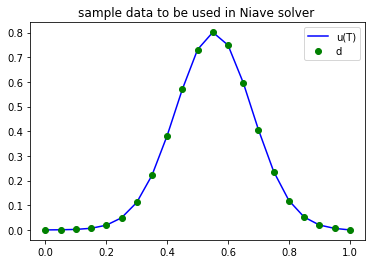

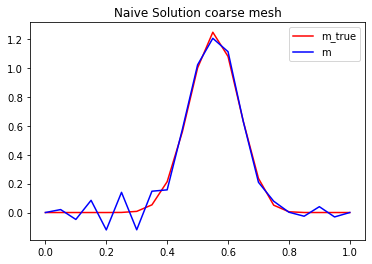

In [7]:
# Edit nx or noise_std_dev to see the impact on the naive solver

nx = 20 # default 20
noise_std_dev = 1e-4 # default


T = 1.0
L = 1.0
k = 0.005

nt = 100


h = L/float(nx)
dt = T/float(nt)

x = np.linspace(0.+h, L-h, nx-1) #place nx-1 equispace point in the interior of [0,L] interval
m_true = np.power(.5,-36)*np.power(x,20)*np.power(1. - x, 16)  #smooth true initial condition
#m_true = 0.5 - np.abs(x-0.5)                                    #initial condition with a corner
u_true = solveFwd(m_true)

d = u_true + noise_std_dev*np.random.randn(u_true.shape[0])

m = naiveSolveInv(d)

plot(u_true, "-b", label = 'u(T)')
plot(d, "og", label = 'd')
plt.legend()
plt.title('sample data to be used in Niave solver ')
plt.show()


plot(m_true, "-r", label = 'm_true')
plot(m, "-b", label = 'm')
plt.legend()
plt.title('Naive Solution coarse mesh')
plt.show()


<div style="background-color: #cce5ff; padding: 10px;">

If you have played around with the code above you will see that:
- for a very coarse mesh (`nx = 20`) and no measurement noise (`noise_std_dev = 0.0`) the naive solution is quite good
- for a finer mesh (`nx = 100`) and/or even small measurement noise (`noise_std_dev = 1e-4`) the naive solution is very poor

</div>    

<hr>
<div style="background-color: #ccffcc; padding: 10px;">
    
### Why does the naive solution fail?

Let $v_n = \sqrt{\frac{2}{L}} \sin\left( n \, \frac{\pi}{L} x \right)$ with $n=1,2,3, \ldots$, then we have that

$$ \mathcal{F} v_n = \lambda_n v_n, \quad \text{where the eigenvalues } \lambda_n = e^{-kT\left(\frac{\pi}{L} n \right)^2}. $$

**Note 1**:
- Large eigenvalues $\lambda_n$ corresponds to smooth eigenfunctions $v_n$;
- Small eigenvalues $\lambda_n$ corresponds to oscillatory eigenfuctions $v_n$.

The figure below shows that the eigenvalues $\lambda_n$ decays extremely fast, that is the matrix $F$ (discretization of the forward model $\mathcal{F}$) is extremely ill conditioned.

</div>

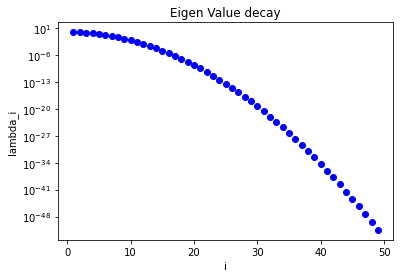

In [8]:
T = 1.0
L = 1.0
k = 0.005

i = np.arange(1,50)
lambdas = np.exp(-k*T*np.power(np.pi/L*i,2))

plt.semilogy(i, lambdas, 'ob')
plt.xlabel('i')
plt.ylabel('lambda_i')
plt.title('Eigen Value decay')
plt.show()

<hr>
<div style="background-color: #ccffcc; padding: 10px;">
    
**Note 2**: The functions $v_n$ ($n=1,2,3, \ldots$) form an orthonormal basis of $L^2([0,1]$). 

That is, every function $f \in L^2([0,1])$ can be written as

$$ f = \sum_{n=1}^\infty \alpha_n v_n, \text{ where } \alpha_n = \int_0^1 f v_n dx.$$

Consider now the noisy problem

$$ d = \mathcal{F}m_{\rm true} + \eta, $$

where
- $d$ is the data (noisy measurements)
- $\eta$ is the noise: $\eta(x) = \sum_{n=1}^\infty \eta_n v_n(x)$
- $m_{\rm true}$ is the true value of the parameter that generated the data
- $\mathcal{F}$ is the forward heat equation

Then, the naive solution to the inverse problem $\mathcal{F}m = d$ is

$$ m = \mathcal{F}^{-1}d = \mathcal{F}^{-1}\left( \mathcal{F}m_{\rm true} + \eta \right) = m_{\rm true} + \mathcal{F}^{-1} \eta = m_{\rm true} + \mathcal{F}^{-1} \sum_{n=1}^{\infty} \eta_n v_n = m_{\rm true} +  \sum_{n=1}^{\infty} \frac{\eta_n}{\lambda_n} v_n. $$

If the coefficients $\eta_n = \int_0^1 \eta(x) \, v_n(x) \, dx$ do not decay sufficiently fast with respect to the eigenvalues $\lambda_n$, then the naive solution is unstable.

This implies that oscillatory components can not reliably be reconstructed from noisy data since they correspond to small eigenvalues.

This means we must take different approach even to a relatively simple looking problem which may require filtering or computationaly expensive calculations. This is with an even sample of data to use. So we might consider looking to PINNs

<hr>

<div style="background-color: #e6ccff; padding: 10px;">

## Next steps

Now we've gone through a Naive manial approach to solving a simple 1D Heat equation we look at the benefits of using neural networks to solve more complex equations starting with the next notebook linked below: 
    
[Burgers Equation PINN Example](PINNs_BurgersEquationExample.ipynb)
    
</div>